# Lab 7: Estimating Causal Effects via Instrumental Variables
Welcome to the seventh DS102 lab! 

The goals of this lab is to implement and get better understanding of Instrumental Variables discussed in  [Discussion 07](https://data102.org/fa20/assets/disc/disc07/DIS7.pdf). Along with Inverse Propensity Scaling which we discussedin Lecture, Instrumental Variables are often used to determine causal effects. We highly recommend that you watch the video on [bCourses](https://bcourses.berkeley.edu/courses/1499039/pages/discussion-7?module_item_id=16010582) before attempting this lab.

The code you need to write is commented out with a message "TODO: fill in".

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission {-}
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Wednesday, Oct 29th, 2020 at 11:59 PM. PST**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import itertools
from ipywidgets import interact, interactive

import hashlib

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Instrumental Variables Background

Suppose that we measure $X_1$, the number of books a student read in the last year, and we are intrested in determing how $X_1$ affects an observed target outcome $Y$, the student's SAT score. The effect we are interested in is **causal** because we want to know how $Y$ changes if all randomness other than $X_1$ remains fixed, and only $X_1$ changes. We will refer to $X_1$ as the "treatment". In general, $X_1$ might be multi-dimensional, however for the purpose of this exercise we take $X_1 \in\mathbb{R}$.

Suppose there's also a confounder $X_2$, which is the income of the student's family. We don't observe $X_2$, but it affects both the number of books the student reads (wealthier families may have more access to books) and the student's SAT score (wealthier students may have more access to SAT tutoring).

We assume that the outcome is generated as a linear function of the confounder $X_2$ and treatment $X_1$, with additive noise $\epsilon$:
$$$$
$$Y = \beta_1 X_1 + \beta_2 X_2 + \epsilon.$$

The goal is to estimate $\beta_1$, the true causal effect of the number of books a student reads on their SAT score.

### Danger of bias
As we saw in Discussion 7, if the confounder $X_2$ is highly correlated with $X_1$, performing ordinary least squares (OLS) on the observed data $X_1$, $Y$ can lead to very biased results. 

### Instrumental variables (IVs) and two-stage least squares (2SLS)

One way to get around this issue is by using **instrumental variables (IVs)**. A valid instrument $Z$ is a variable which is independent of the confounder $X_2$, and affects $Y$ only through $X_1$. For example, we can create such an instrument $Z$ by employing *encouragement design*, where we randomly assign students to "readathons" of different durations. See the figure below for a causal diagram:

![](causal_diagram.png)

Using the instrumental variable $Z$, we can estimate $\beta_1$ by first "guessing" $X_1$ from $Z$ using ordinary least squares (OLS) (denoted $\hat X_1$), and then regressing $Y$ onto $\hat X_1$ (instead of $X_1$) using OLS as well. This procedure is known as **two-stage least squares (2SLS)**. 

In this lab, we will observe the bias that can occur when naively performing OLS on the observed data $X_1, Y$, and also how employing 2SLS can achieve a better estimate of $\beta_1$.

# Model setup

Suppose that we have historical data from $n=10,000$ different students. Suppose we observe the following variables: 

$X_1^{(i)} =$ number of books the student read in the last year, 

$Z^{(i)} = $ duration of the "readathon" at the student's school. *Note: This is sligtly different from the setup in Discussion 7 where it was a binary variable* 

$Y^{(i)} = $ the student's SAT score. 

Suppose that the student's family income $X_2^{(i)}$ affects both $X_1^{(i)}$ and $Y^{(i)}$, but is **not observed**.

## Data Generation
The student's SAT score is linear in the number of books the student read and the student's family income:
$$Y^{(i)} = \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} + \epsilon^{(i)}.$$ 

The number of books a student reads is linear in whether or not there was a readathon and the student's family income:
$$X_1^{(i)} = \gamma_1 Z^{(i)} + \gamma_2 X_2^{(i)} + \epsilon'^{(i)},$$

### The true model was generated in the following manner:
 - Sample $Z^{(i)}\sim N(20,5)$    $\ \longleftarrow\ $   *Duration of Readathon for student* $i$ 
 - Sample $X_2^{(i)} \sim \text{Normal}(50, 10)$   $\ \longleftarrow\ $   *Income in thousands for the family of student* $i$ **(unobserved variable)**
 - Generate $X_1^{(i)}$ by setting $\gamma_1 = \gamma_2 =1$ and sampling a noise $\epsilon'^{(i)}\sim N(0,5)$   $\ \longleftarrow\ $  *Number of books read by student* $i$
 - Generate $Y_i^{(i)}$ by setting $\beta_1 = 5$, $\beta_2 = 12$  and sampling a noise $\epsilon^{(i)}\sim N(0,10)$ $\ \longleftarrow\ $  *SAT score for student* $i$

## Load the data
Run the cells below to load and plot the data.

In [2]:
# Do not modify: Just run this to load the data
student_data = pd.read_csv("SAT_data.csv")
student_data.head()

,NumBooks,Income,SAT,ReadathonDuration
0,54.0,45.473122,799.0,16.0
1,71.0,53.064868,991.0,15.0
2,79.0,52.522466,1017.0,19.0
3,92.0,61.322441,1197.0,23.0
4,65.0,53.453239,982.0,12.0


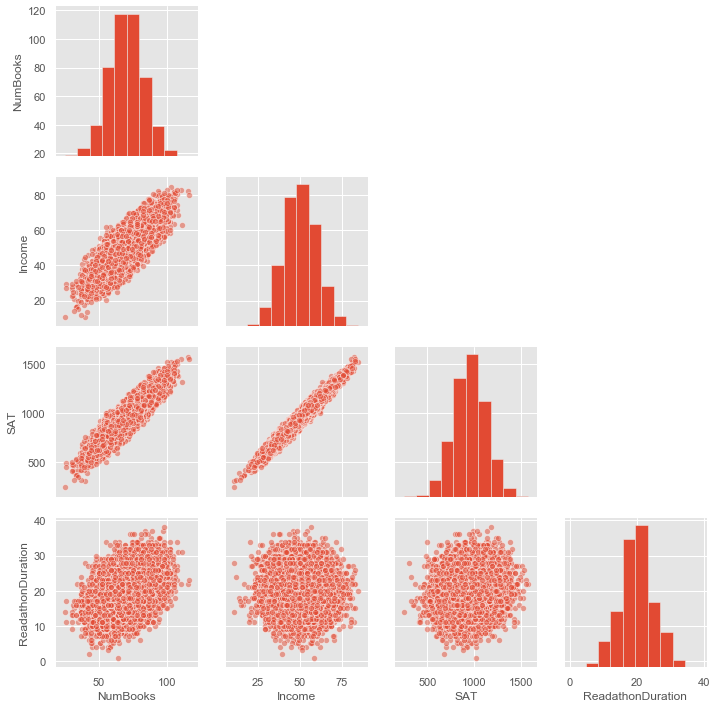

In [3]:
# make a pairplot illustrating the pairwise correlations between different columns in the dataset
fig = sns.pairplot(student_data,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

In the plot above on the main diagonal we have the histograms of each variable, and on the off-diagonals we have scatter plots illustrating the corelations between pair of variables. 

# Question 1: Understanding the Model

## 1.a Correlations between variables
### i) `TODO`: Just by inspecting the pairplot above rank in order from most correlated to least correlated the following pairwise relationships: `X_1 &  X_2`, `X_1 &  Y`, `X_1 & Z`, `X_2 & Y`, `X_2 & Z`, `Y & Z`
### ii) `TODO`: Which of the above pairs are independent.

i) `TODO`:  X_2 & Y, X_1 &  Y, X_1 &  X_2, X_1 & Z, Y & Z, X_2 & Z

ii) `TODO`: Z & X_2

## 1.b Understanding the marginal impacts
### `TODO`: Inspect the Data Generation section above, and answer the following questions. 
#### i) What is the true causal effect of an extra book read on the SAT score (i.e. if you hold everything else constant and you read one more book by how much will the SAT score change)?
#### ii) What is the true causal effect of increasing income by \$1000 on the SAT score?
#### iii) What is the true causal effect of an extra readathon day on the number of books read?
#### iv) What is the true causal effect of increasing income by \$1000 on the number of books read?

i) `TODO`: 5

ii) `TODO`: 12

iii) `TODO`: 1

iv) `TODO`: 1

## Ordinary Least Squares
If we had access to income data $X_2$, then we could estimate directely $\beta_1$, $\beta_2$, $\gamma_1$, $\gamma_2$ from the data by setting up a linear regression problem and finding Ordinary Least Squares estimator. 

$$\hat\beta_1, \hat\beta_2 = \arg\min_{\beta_1, \beta_2}\Vert Y - \beta_1X_1 - \beta_2X_2 \Vert_2^2$$
$$\hat\gamma_1, \hat\gamma_2 = \arg\min_{\gamma_1, \gamma_2}\Vert X_1 - \gamma_1Z - \gamma_2X_2 \Vert_2^2$$

To find OLS estimators we will use [`sm.OLS`](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html?highlight=ols) from `statsmodels.api`.

In [4]:
# No TODOs here: Just examine the code
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [5]:
# Computing the OLS estimators for gamma_1 and beta_2
gammas_model = fit_OLS_model(student_data, 'NumBooks', ['ReadathonDuration', 'Income'])
print(gammas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:               NumBooks   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          9.849e+05
Date:                Mon, 26 Oct 2020   Prob (F-statistic):                        0.00
Time:                        09:40:05   Log-Likelihood:                         -30390.
No. Observations:               10000   AIC:                                  6.078e+04
Df Residuals:                    9998   BIC:                                  6.080e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [6]:
# Print the fitted_estimators
gammas = gammas_model.params
print("The estimated causal effect on number of books read of an additional Readathon day is {:.2f}".format(gammas[0]))
print("The estimated causal effect on number of books read of an additional $1000 is {:.2f}".format(gammas[1]))
# The numbers you get should be very close to you answer in 1.b

The estimated causal effect on number of books read of an additional Readathon day is 1.00
The estimated causal effect on number of books read of an additional $1000 is 1.00


## 1.c Estimate causal effect of `NumBooks` and `Income` on the SAT Score

In [7]:
# Compute OLS estimators for beta_1 and beta_2
betas_model = fit_OLS_model(student_data, 'SAT', ['NumBooks', 'Income'])# TODO: fill in
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    SAT   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.546e+07
Date:                Mon, 26 Oct 2020   Prob (F-statistic):                        0.00
Time:                        09:40:05   Log-Likelihood:                         -37348.
No. Observations:               10000   AIC:                                  7.470e+04
Df Residuals:                    9998   BIC:                                  7.471e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [8]:
# Print the fitted_estimators
betas = betas_model.params
print("The estimated causal effect on SAT score of an additional book read is {:.2f}".format(betas[0]))
print("The estimated causal effect on SAT score of an additional $1000 is {:.2f}".format(betas[1]))
# The numbers you get should be very close to you answer in 1.b

The estimated causal effect on SAT score of an additional book read is 4.98
The estimated causal effect on SAT score of an additional $1000 is 12.03


In [9]:
# Validation tests: Do not modify
assert np.abs(betas[0]-5)< 0.1
assert np.abs(betas[1]-12)< 0.1
print("Test passed!")

Test passed!


In Question 1 we saw how we can estimate all causal relationships if we have access to the income variable. However in our actual data we **do not observe Income**.

## Goal: estimate $\beta_1$, the true causal effect of the number of books a student reads on their SAT score without access to the Income variable.

# 2. Naive OLS: OLS on the observed variables $X_1$, $Y$.
The confounding variable $X_2$ (family income) is unfortunately unobserved. We will start by somewhat "naively" attempting to estimate the causal effect $\beta_1$ by using plain linear regression (OLS) on the observed variables $X_1$ and $Y$. This time we will include an intercept term:

$$\hat\beta_1, \hat c = \arg\min_{\beta_1, c} \Vert Y - \beta_1X_1 - c \Vert^2_2$$

## 2.a. Fit Naive OLS

In [10]:
# TODO: Fit OLS parameters to predict Y from X_1.
beta_naive_model = fit_OLS_model(student_data, 'SAT', 'NumBooks', intercept = True) # TODO:fill in
print(beta_naive_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SAT   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                 5.117e+04
Date:                Mon, 26 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:40:05   Log-Likelihood:                -56726.
No. Observations:               10000   AIC:                         1.135e+05
Df Residuals:                    9998   BIC:                         1.135e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.8488      4.074     10.518      0.0

In [11]:
# Validation tests: Do not modify
params = beta_naive_model.params
assert len(params)==2
assert np.abs(params[0] - 42.85)<0.5
assert np.abs(params[1] - 12.96)<0.2
print('Test Passed!')

Test Passed!


In [12]:
print("The Naive OLS estimate of beta_1 is {:.2f}, while the true beta_1 is {}".format(beta_naive_model.params[1], 5))

The Naive OLS estimate of beta_1 is 12.96, while the true beta_1 is 5


## 2.b Does the Naive approach overestimate or under estimate the value of reading books?
`TODO`: Answer this question by comparing the naive estimate and the true value of $\beta_1$

`TODO`: It overestimates the effect of number of books read. The bias is due to the fact that the confounder has a positive effect on both the number of books read and the SAT score.

In [13]:
# No TODOs here, just run this call and understand what this function is doing.
def compute_OLS_predictions(input_array, input_params):
    """Calculates OLS predictions from fitted OLS parameters, input_params.
    
    Args:
      input_array: numpy array with n entries, where each entry corresponds with a feature value for a given student.
      input_params: numpy array with 2 entries, where the entries are [intercept, beta_hat]. 
        The intercept is a constant term, so the final OLS predictions should be 
        predictions = intercept + beta_hat*input_array.

    Returns:
      numpy array with n entries containing predictions from input_array.
    """
    predictions = input_params[0] + input_params[1] * input_array 
    return predictions

## 3.a Stage 1: Predict treatment variable $\hat{X}_1$ from instrumental variable $Z$

### Fit OLS parameters to predict $X_1$ from $Z$
$$\hat\gamma_1, \hat c = \arg\min_{\gamma_1, c} \Vert X_1 - \gamma_1Z - c\Vert_2^2$$

In [14]:
# TODO: Fit OLS parameters to predict X_1 from Z
gamma1_model = fit_OLS_model(student_data, 'NumBooks', 'ReadathonDuration', intercept=True) # TODO: fill in
print(gamma1_model.summary())

                            OLS Regression Results                            
Dep. Variable:               NumBooks   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1927.
Date:                Mon, 26 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:40:05   Log-Likelihood:                -38391.
No. Observations:               10000   AIC:                         7.679e+04
Df Residuals:                    9998   BIC:                         7.680e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                50.1628      0.46

In [15]:
# Validation tests: Do not modify
params = gamma1_model.params
assert len(params)==2
assert np.abs(params[0] - 50.16)<0.5
assert np.abs(params[1] - 1)<0.1
print('Test Passed!')

Test Passed!


In [16]:
print("The OLS estimate of gamma_1 is {:.3f}, while the true gamma_1 is {}".format(gamma1_model.params[1], 1))

The OLS estimate of gamma_1 is 0.996, while the true gamma_1 is 1


### `TODO`: We observe that the estimate of $\gamma_1$ above is very close to the true value, even though we don't make use of the `Income` variable. How can you explain this?
**Hint**: Think about independence

`TODO`: The instrument $Z$ is not correlated with income, this the $\gamma_1$ estimate is unbiased.

### Now we can use the OLS model above to create $\hat X_1$ predictions

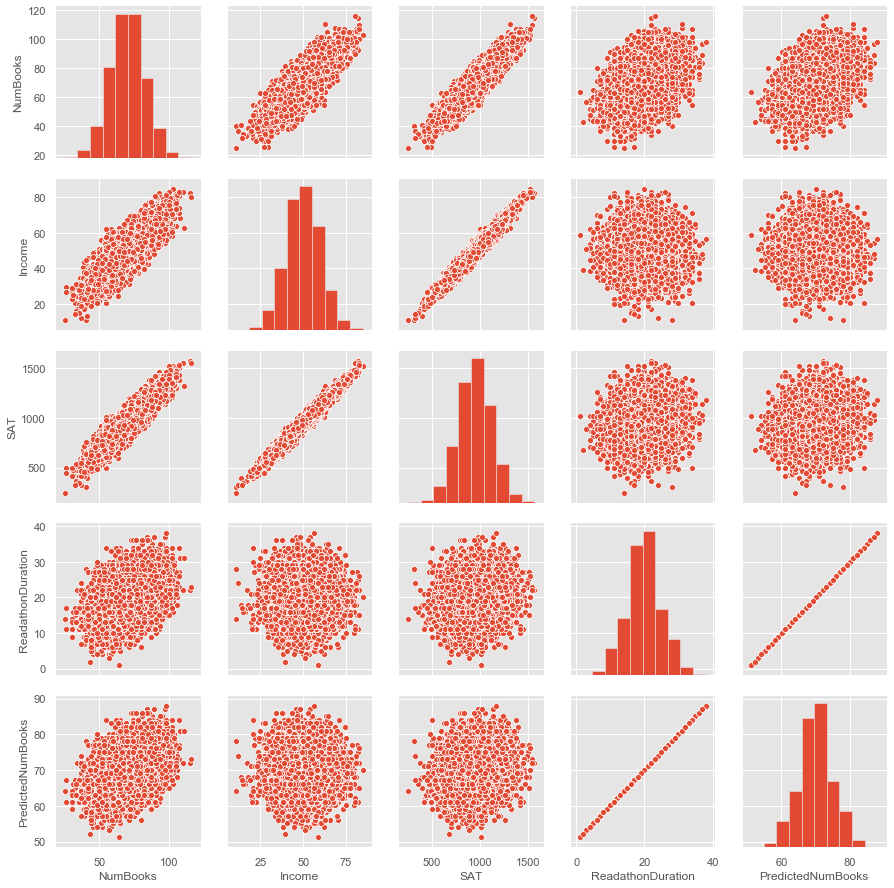

In [17]:
# Compute predictions for number of books read
intercept_OLS = gamma1_model.params[0]
gamma1_OLS = gamma1_model.params[1]
X_1_hat = intercept_OLS + gamma1_OLS*student_data['ReadathonDuration']

# Add the predictions to the student_data dataframe
student_data['PredictedNumBooks'] = X_1_hat
student_data.head()
sns.pairplot(student_data)

## 3.b Stage 2: Estimate target $Y$ from predicted treatment variable $\hat{X}_1$
Fit OLS parameters to predict $Y$ from the predicted $\hat X_1$
$$\hat \beta_1, \hat c = \arg\min_{\beta_1, c}\Vert Y-\beta_1\hat X_1 - c\Vert_2^2$$

In [18]:
# TODO: Fit OLS parameters to predict Y from the predicted X_1_hat.
beta1_model = fit_OLS_model(student_data, 'SAT', 'PredictedNumBooks', intercept=True)
print(beta1_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SAT   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     191.8
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           3.24e-43
Time:                        09:40:14   Log-Likelihood:                -65687.
No. Observations:               10000   AIC:                         1.314e+05
Df Residuals:                    9998   BIC:                         1.314e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               611.8673     24.51

In [19]:
# Validation tests: Do not modify
params = beta1_model.params
assert len(params)==2
assert np.abs(params[0] - 612)<5
assert np.abs(params[1] - 4.84)<0.3
print('Test Passed!')

Test Passed!


In [20]:
print("The 2SLS estimate of beta_1 is {:.3f}, while the true value is {}".format(beta1_model.params[1], 5))

The 2SLS estimate of beta_1 is 4.835, while the true value is 5


## 3.c. Answer the following conceptual questions:

### i) Which technique produced a better estimate of $\beta_1$, naive OLS or 2SLS?
### ii) Give a plausible scenario where organizing a Readathon would not serve as an appropriate Intrumental Variable (IV).
**Hint** Recall what properties should an IV satisfy

i) `TODO`: 2SLS produced a much more accurate estimate of the effect of number of books read on the SAT score.

ii) `TODO`: If the Readtathon is somehow correlated with the income, for example since schools in lower income districts might only be able to run reathathons for a shorter period of time and might have fewer book selections.

Yay, you've made it to the end of Lab 7!


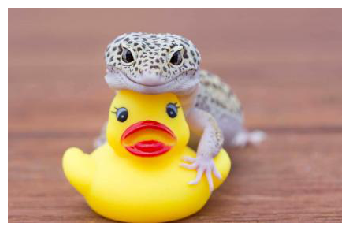

In [21]:
import matplotlib.image as mpimg
img = mpimg.imread('cute_gecko.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of Lab 7!")
plt.show()